# Task 1: Introduction

![Movies Collage](https://i.imgur.com/T7V0VZ6.png)

For this project we are going to create a recommendation engine for movies for users based on there past behaviour.

---

We will focus on the **collaborative filtering** approach, that is: 

The user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

---

Note: This notebook uses `python 3` and these packages: `pandas`, `numpy`, `matplotlib` and `scikit-surprise`

We can install them using:
```Shell
pip3 install pandas matplotlib numpy scikit-surprise
```

## 1.1: Installing Libraries

In [14]:
print('>> Installing Libraries')

!pip3 install pandas matplotlib numpy scikit-surprise #shell command not terminal command -- thats'swhy exclamation mark

print('>> Libraries Installed')

>> Installing Libraries
Defaulting to user installation because normal site-packages is not writeable
>> Libraries Installed


## 1.2: Importing Libraries

First of all, we will need to import some libraries. This includes surprise which we will use to create the recommendation system.

In [15]:
print('>> Importing Libraries')

import pandas as pd

#surprise library is for recommender systems
from surprise import Reader, Dataset, SVD 
#Reader, Dataset - to surprise set
#Singular Value Decomposition(SVD) - for recommender systems model making

from surprise.accuracy import rmse, mae #accuracy and all
from surprise.model_selection import cross_validate #as we dont have test data - cross validate will help

print('>> Libraries imported.')

>> Importing Libraries
>> Libraries imported.


# Task 2: Importing Data

We will use open-source dataset from GroupLens Research ([movielens.org](http://movielens.org))

## 2.1: Importing the Data

The dataset is saved in a `ratings.csv` file. We will use pandas to take a look at some of the rows.

In [ ]:
df = pd.read_csv('ratings.csv')
df.head()

## 2.2 Dropping timestamp

We won'theade using the timestamp when user gave the particular rating. So we will drop that column.

In [17]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 2.3 Check for Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [18]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

# Task 3: EDA (Exploratory data analysis)

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics.

## 3.1 Number of movies/users

In [19]:
n_movies = df['movieId'].nunique()
n_users = df['userId'].nunique()
print(n_movies,'\n', n_users)

9724 
 610


## 3.2 Sparsity of our data

Sparsity (%) = `(No of missing values/ (Total Values))X100`

In [20]:
available_ratings = df['rating'].count()
total_ratings = n_movies*n_users  #Total number of possible ratings
missing_Ratings = total_ratings - available_ratings

sparsity  = (missing_Ratings/total_ratings)*100
print(sparsity)

98.30003169443864


## 3.3 Ratings Distribution

<AxesSubplot:>

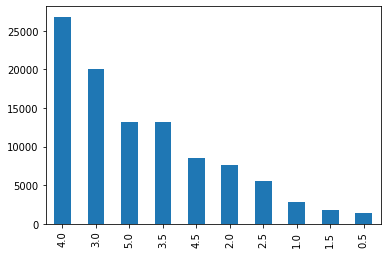

In [21]:
df['rating'].value_counts().plot(kind='bar') #Value_count - to count freq of diff ratings
#directly used the plot function

# Task 4: Dimensionality Reduction

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

## 4.1 Filter movies with less than 3 ratings

In [22]:
filter_movies = df['movieId'].value_counts() > 3 #a list of true and false
filter_movies = filter_movies[filter_movies].index.tolist() #finally converting into list
# filter_movies

## 4.2 Filter users with less than 3 movies rated

In [23]:
filter_users = df['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()

## 4.3 Remove rarely rated movies and rarely rating users

In [24]:
df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]

# Task 5: Create Training and Test Sets

## 5.1 Columns used for training

In [25]:
cols = ['userId', 'movieId', 'rating' ]

## 5.2 Create surprise dataset

In [32]:
reader = Reader(rating_scale = (0.5,5)) #imported priorly - rating to range from 0.5 to 5
#using reader method - to specify range
data = Dataset.load_from_df(df[cols], reader)
#using Dataset method

## 5.3 Create Train-set and Prediction-set

In [34]:
trainset = data.build_full_trainset()

antiset = trainset.build_anti_testset() 
#will contain user and movies who do not have ratings yet and requires a prediction

trainset

# Task 6: Creating and training the model

## 6.1 Creating the model

**SVD (Singular Value Decomposition)**

Interaction Matrix = A X B X C

In [35]:
#svd - matrix decomposition method 
#to factorise the given matrix and then multiply the factors back
#to get the complete interaction matrix - missing values will dissapear
algo = SVD(n_epochs=25, verbose=True) #will repeat 25 times to reduce the error

## 6.2 Training the model

**Mean Absolute Error (MAE)**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 

**Root mean squared error (RMSE)**:  RMSE is the square root of the average of squared differences between prediction and actual observation.

In [37]:
#will use cross validation - the k-fold way
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
#verbose is uded to showon screen while training
print(">>training done")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

# Task 7: Predictions

## 7.1 Predict ratings for all pairs (user, items) that are NOT in the training set.

In [38]:
predictions = algo.test(antiset)

In [42]:
predictions[1] #r_ui - overall avg rating, est - predicted rating for this user

Prediction(uid=1, iid=1704, r_ui=3.529119856267723, est=4.54715134607581, details={'was_impossible': False})

## Recommending top 3 movies movies based on predictions

In [43]:
from collections import defaultdict

def get_top_n(predictions, n):
    top_n = defaultdict(list) 
    for uid, iid, _, est, _ in predictions: #_ means we don't care about them
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse=True) #x - iid, x[1] - est(estimated- predicted ratings)
        #sort fxn is ascending by default
        top_n[uid] = user_ratings[:n]
    return top_n
    pass


top_n = get_top_n(predictions, n=3) #printing top3 recommendations
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings])

1 [318, 908, 912]
2 [898, 1262, 720]
3 [109487, 81834, 2788]
4 [720, 1262, 745]
5 [2959, 858, 4973]
6 [260, 2571, 4886]
7 [318, 1283, 912]
8 [5618, 898, 1223]
9 [4973, 318, 3030]
10 [5902, 3083, 31364]
11 [1204, 527, 1262]
12 [356, 527, 1258]
13 [858, 296, 720]
14 [1225, 1207, 2160]
15 [1148, 720, 904]
16 [1233, 2160, 56367]
17 [1204, 898, 1242]
18 [750, 720, 246]
19 [527, 1233, 5747]
20 [345, 1199, 1250]
21 [14, 1204, 1028]
22 [2571, 1210, 110]
23 [1272, 1148, 720]
24 [720, 260, 3451]
25 [110, 356, 1617]
26 [720, 741, 2924]
27 [109487, 318, 81834]
28 [3421, 111, 4886]
29 [1225, 2858, 3030]
30 [47, 2858, 720]
31 [2959, 318, 1262]
32 [1136, 720, 3030]
33 [3147, 1225, 5618]
34 [1262, 1193, 1225]
35 [44195, 2959, 1204]
36 [1148, 44555, 1193]
37 [4226, 7361, 4878]
38 [4011, 1250, 720]
39 [898, 318, 4973]
40 [1221, 1213, 608]
41 [912, 74458, 6620]
42 [7438, 720, 778]
43 [50, 101, 260]
44 [296, 1223, 3703]
45 [80906, 1247, 527]
46 [898, 1193, 2160]
47 [908, 3451, 1262]
48 [109487, 2028, 898]